In [1]:
import torch

MODELS_FOLDER = 'models'
# torch.cuda.is_available = lambda: False
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## Bernoulli Naive Bayes

In [2]:
import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
try:
  CountVec = joblib.load(f'{MODELS_FOLDER}/model_bayes/countvec.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

In [4]:
CountVec

CountVectorizer(binary=True, lowercase=False)

In [5]:
CountVec.vocabulary_

{'USERNAME': 20502,
 'Palangga': 15535,
 'ka': 32210,
 'man': 35904,
 'sang': 44342,
 'mga': 36751,
 'taga': 46406,
 'Bacolod': 2311,
 'vp': 48733,
 'Let': 10756,
 'Leni': 10622,
 'Lead': 10541,
 'MonLaurista': 12862,
 'Grabeh': 6955,
 'ang': 22554,
 'loilo': 34438,
 'namon': 38534,
 'Kiko': 9742,
 'Robredo': 17387,
 'iloilo': 30940,
 'kakampinkLaban': 32505,
 'Who': 21275,
 'dafuq': 26253,
 'is': 31703,
 'Jose': 8908,
 'Montemayor': 12881,
 'Jr': 8933,
 'Di': 5045,
 'na': 37317,
 'nakakatuwa': 38224,
 'yung': 49644,
 'mukha': 37204,
 'ni': 39296,
 'Mar': 12232,
 'Roxas': 17522,
 'sa': 44084,
 'TV': 19569,
 'Nakakatamad': 13765,
 'manood': 36086,
 'national': 38951,
 'elections': 27676,
 'via': 48554,
 'Binay': 2732,
 'will': 49116,
 'be': 23672,
 'staring': 45721,
 'in': 31049,
 'movie': 37168,
 'called': 24856,
 'The': 19905,
 'Dark': 4795,
 'Force': 6339,
 'Awakens': 1775,
 'Nog': 14189,
 'Hambog': 7567,
 'fact': 28271,
 'that': 46924,
 'we': 48925,
 'are': 22825,
 'even': 28045,
 '

In [6]:
try:
  BayesModel = joblib.load(f'{MODELS_FOLDER}/model_bayes/bayes.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

In [7]:
BayesModel

BernoulliNB()

In [8]:
def predict_bayes(inputs: list):
  inputs_transformed = CountVec.transform(inputs)
  predictions = BayesModel.predict(inputs_transformed)
  return predictions

def predict_proba_bayes(inputs: list):
  inputs_transformed = CountVec.transform(inputs)
  predictions = BayesModel.predict_proba(inputs_transformed)
  return predictions

In [9]:
predict_bayes([
  'gago ka putang ina mo',
  'tangina mo',
  'tangina mo pare',
  'i love you uwu',
])

array([1, 1, 1, 0])

In [10]:
predict_proba_bayes([
  'gago ka putang ina mo',
  'tangina mo',
  'tangina mo pare',
  'i love you uwu',
])

array([[8.77216649e-05, 9.99912278e-01],
       [1.85016770e-02, 9.81498323e-01],
       [7.60345090e-03, 9.92396549e-01],
       [9.13134258e-01, 8.68657417e-02]])

## LSTM

In [11]:
import calamancy

Calamancy = calamancy.load("tl_calamancy_md-0.1.0")

Calamancy

/home/nate/miniconda3/lib/python3.9/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn_msg)
/home/nate/miniconda3/lib/python3.9/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_lg' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn

In [12]:
import pandas as pd
import numpy as np
from torch import Tensor

def get_calamancy_tokens(data):
  # Allows it to work with both dataframes and
  # simple lists of strings
  if isinstance(data, pd.Series):
    data = data.values

  samples = []

  for sample in Calamancy.pipe(data):
    tokens = [
      token
      for token 
      in sample
    ]

    samples.append(tokens)

  return samples

def get_token_vectors(tokens):
  vectors = []

  for sample in tokens:
    vector = Tensor(np.array([token.vector for token in sample]))

    vectors.append(vector)

  return vectors

def get_input_lengths(inputs):
  return [len(sample) for sample in inputs]

/tmp/ipykernel_38461/2087834200.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [13]:
import torch
from torch import nn

INPUT_SIZE = 200
NUM_OF_HIDDEN_NODES = 50
OUTPUT_SIZE = 2

In [14]:
class LstmModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(
      INPUT_SIZE,
      NUM_OF_HIDDEN_NODES,
      batch_first=True,
    )
    self.linear = nn.Linear(NUM_OF_HIDDEN_NODES, OUTPUT_SIZE)

    self.lstm_output = None
    self.lstm_packed_output = None
    self.lstm_input_lengths = None
    self.lstm_last_valid_outputs = None
    self.lstm_hidden_state = None
    self.lstm_cell_state = None

  def forward(self, input):
    self.lstm_packed_output, (self.lstm_hidden_state, self.lstm_cell_state) = self.lstm(input)

    # Unpack padded sequence to get last valid output state
    # before padding
    self.lstm_output, self.lstm_input_lengths = nn.utils.rnn.pad_packed_sequence(self.lstm_packed_output, batch_first=True)
    self.lstm_last_valid_outputs = self.lstm_output[torch.arange(self.lstm_output.size(0)), self.lstm_input_lengths - 1]

    linear_output = self.linear(self.lstm_last_valid_outputs)

    return linear_output

Lstm = LstmModel()
Lstm.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_lstm/lstm_state_dict.pth",
    map_location=DEVICE,
  )
)

Lstm.to(DEVICE)

LstmModel(
  (lstm): LSTM(200, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [15]:
Lstm.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0299,  0.1702, -0.0789,  ..., -0.0876,  0.0782, -0.0295],
                      [-0.0865, -0.2574, -0.1096,  ..., -0.0537, -0.1267, -0.1884],
                      [ 0.1750,  0.0076, -0.1551,  ..., -0.2672,  0.1077,  0.1745],
                      ...,
                      [ 0.0542, -0.1413,  0.0746,  ...,  0.0926, -0.2215, -0.0346],
                      [-0.0894, -0.0629, -0.2509,  ...,  0.0662, -0.1074,  0.1109],
                      [-0.0335, -0.0938,  0.1750,  ..., -0.0449, -0.1669, -0.1992]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0409,  0.1266, -0.0090,  ..., -0.0003,  0.0947, -0.1279],
                      [ 0.0620,  0.1572, -0.0572,  ..., -0.1911,  0.1077,  0.1340],
                      [ 0.0410, -0.1172, -0.0481,  ..., -0.0174,  0.0447, -0.0930],
                      ...,
                      [ 0.0430, -0.0281,  0.0648,  ...,  0.1466,  0.0659, -0.00

In [16]:
softmax_function = nn.Softmax(dim=1)

In [17]:
def process_lstm(inputs: list):
  tokens = get_calamancy_tokens(inputs)
  vectors = get_token_vectors(tokens)
  sequence_lengths = get_input_lengths(tokens)
  vectors_padded = nn.utils.rnn.pad_sequence(
    vectors,
    batch_first=True,
  )
  vectors_packed = nn.utils.rnn.pack_padded_sequence(
    vectors_padded,
    sequence_lengths,
    batch_first=True,
    enforce_sorted=False,
  )
  return vectors_packed.to(DEVICE)

def data_loader_lstm(vectors, batch_size):
    for i in range(0, len(vectors), batch_size):
        yield vectors[i:i+batch_size]

def predict_proba_lstm(inputs: list):
  all_predictions = []

  for samples in data_loader_lstm(inputs, 16):
    vectors = process_lstm(samples)
    predictions = Lstm(vectors)
    probabilities = softmax_function(predictions)
    all_predictions.append(probabilities)

  return torch.cat(all_predictions).cpu()

def predict_lstm(inputs: list):
  probabilities = predict_proba_lstm(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities



In [18]:
predict_proba_lstm([
  'mahal kita, gago',
  'mahal na mahal kita',
  'tangina pare mo',
  'tangina mo pare',
  'pare mo tangina',
  'i love you uwu',
])

tensor([[0.1697, 0.8303],
        [0.5645, 0.4355],
        [0.2567, 0.7433],
        [0.3064, 0.6936],
        [0.2445, 0.7555],
        [0.8253, 0.1747]], grad_fn=<ToCopyBackward0>)

In [19]:
predict_lstm([
  'mahal kita, gago',
  'mahal na mahal kita',
  'tangina pare mo',
  'tangina mo pare',
  'pare mo tangina',
  'i love you uwu',
])

tensor([1, 0, 1, 1, 1, 0])

## mBERT

In [20]:
BERT_MAX_LENGTH = 255
BERT_MODEL_NAME = "bert-base-multilingual-uncased"

In [21]:
from transformers import (
  BertForSequenceClassification,
  BertTokenizer
)

/home/nate/miniconda3/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/nate/miniconda3/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [22]:
bert_tokenizer = BertTokenizer.from_pretrained(
  BERT_MODEL_NAME
)

In [23]:
Bert = torch.load(
  f'{MODELS_FOLDER}/model_bert/bert_state_dict.pth',
  map_location=DEVICE,
)

Bert.to(DEVICE)

Bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [24]:
def process_bert(inputs):
    input_ids = []
    attention_masks = []

    for text in inputs:
        # Tokenize the text
        tokens = bert_tokenizer.tokenize(text)

        # Truncate the tokens if necessary
        if len(tokens) > BERT_MAX_LENGTH - 2:
            tokens = tokens[:BERT_MAX_LENGTH - 2]

        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to token IDs
        token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

        # Pad the token IDs to BERT_MAX_LENGTH
        padding = [0] * (BERT_MAX_LENGTH - len(token_ids))
        token_ids += padding

        # Create attention mask
        attention_mask = [1] * len(tokens) + [0] * len(padding)

        input_ids.append(token_ids)
        attention_masks.append(attention_mask)

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).to(DEVICE)
    attention_masks = torch.tensor(attention_masks).to(DEVICE)

    return input_ids, attention_masks

# Custom data loader
def data_loader(input_ids, attention_masks, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_masks[i:i+batch_size]

def predict_proba_bert(inputs: list):
  with torch.inference_mode():
    input_ids, attention_masks = process_bert(inputs)

    all_predictions = []
    for batch_input_ids, batch_attention_masks in data_loader(input_ids, attention_masks, 5):
      batch_input_ids = batch_input_ids.to(DEVICE)
      batch_attention_masks = batch_attention_masks.to(DEVICE)

      predictions = Bert(
        batch_input_ids,
        attention_mask=batch_attention_masks,
      ).logits

      probabilities = softmax_function(predictions)

      all_predictions.append(probabilities)

    return torch.cat(all_predictions).cpu()

def predict_bert(inputs: list):
  probabilities = predict_proba_bert(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities

In [25]:
bert_results = predict_bert([
  'mahal kita, gago',
  'mahal na mahal kita',
  'tangina pare mo',
  'tangina mo pare',
  'pare mo tangina',
  'i love you uwu',
])

bert_results

tensor([1, 0, 1, 1, 1, 0])

In [26]:
predict_bert([
  'mahal kita, gago',
  'mahal na mahal kita',
  'tangina pare mo',
  'tangina mo pare',
  'pare mo tangina',
  'i love you uwu',
])

tensor([1, 0, 1, 1, 1, 0])

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

LogReg = joblib.load(f'{MODELS_FOLDER}/model_lr/lr.pkl')

LogReg

/home/nate/miniconda3/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LogisticRegression()

## Ensemble Methods

In [28]:
def get_learner_predictions(inputs: list):
  bayes_pred = predict_bayes(inputs)
  lstm_pred = predict_lstm(inputs)
  bert_pred = predict_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred,
    bert_pred,
  ])

def get_learner_predictions_proba(inputs: list):
  bayes_pred = predict_proba_bayes(inputs)
  lstm_pred = predict_proba_lstm(inputs)
  bert_pred = predict_proba_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred.detach().numpy(),
    bert_pred.detach().numpy(),
  ])

In [29]:
get_learner_predictions([
  'mahal kita, gago',
  'mahal na mahal kita',
  'tangina pare mo',
  'tangina mo pare',
  'pare mo tangina',
  'i love you uwu',
])

array([[1, 0, 1, 1, 1, 0],
       [1, 0, 1, 1, 1, 0],
       [1, 0, 1, 1, 1, 0]])

In [30]:
get_learner_predictions_proba([
  'mahal kita, gago',
  'mahal na mahal kita',
  'tangina pare mo',
  'tangina mo pare',
  'pare mo tangina',
  'i love you uwu',
])

array([[[0.08975901, 0.91024099],
        [0.53033497, 0.46966503],
        [0.00760345, 0.99239655],
        [0.00760345, 0.99239655],
        [0.00760345, 0.99239655],
        [0.91313426, 0.08686574]],

       [[0.16967878, 0.83032125],
        [0.5644865 , 0.4355135 ],
        [0.25672707, 0.7432729 ],
        [0.30635694, 0.69364309],
        [0.24452452, 0.75547552],
        [0.82532918, 0.17467083]],

       [[0.25396284, 0.74603713],
        [0.99502808, 0.00497188],
        [0.00291291, 0.99708706],
        [0.00280471, 0.99719524],
        [0.00288033, 0.99711967],
        [0.91299152, 0.08700845]]])

In [31]:
def hard_voting(inputs: list):
  preds = get_learner_predictions(inputs)
  results = np.apply_along_axis(
      lambda x: np.bincount(x).argmax(),
      axis=0,
      arr=preds
  )
  return results

In [32]:
def soft_voting(inputs: list):
  preds = get_learner_predictions_proba(inputs)
  results = np.average(
      preds, axis=0,
  )
  return results

In [33]:
def stacking(inputs: list):
  preds = get_learner_predictions_proba(inputs)

  # Get only the predictions for hate speech
  # Since logistic regression is implemented
  # to assume that you give it the data for 1
  preds = preds[:, :, 1:]

  # Transpose so all learners' preds are on the same row
  transposed_preds = preds.T[0]

  return LogReg.predict_proba(transposed_preds)

## Results

In [34]:
import numpy as np
import pandas as pd
import torch
import math

def shuffle_data_frame(data_frame):
    text = list(data_frame['text'])
    label = list(data_frame['label'])

    assert(len(text) == len(label))

    indices = list(range(len(label)))

    # Make a random number generator that will shuffle list of indices
    # It is seeded to be reproducible
    random_number_generator = np.random.default_rng(seed=0)
    random_number_generator.shuffle(indices)

    shuffled_text = []
    shuffled_labels = []

    # Iterate through the list of indices and add the original data
    # from those shuffled indices
    for index in indices:
        shuffled_text.append(text[index])
        shuffled_labels.append(label[index])

    return pd.DataFrame({
        'text': shuffled_text,
        'label': shuffled_labels,
    })


def get_train_test_split(data_frame: pd.DataFrame, test_size: float):
    """
    Makes a stratified train test split.
    This aims to preserve the distribution between classes.
    """
    if not (1 >= test_size >= 0):
        print('ERROR: test_size must be between 0 and 1')
        return

    data_frame = shuffle_data_frame(data_frame)

    data_frame_length = len(data_frame)
    train_size = 1 - test_size

    nonhate_rows = data_frame[data_frame['label'] == 0]
    nonhate_row_length = len(nonhate_rows)

    nonhate_row_train_size = math.ceil(nonhate_row_length * train_size)

    nonhate_row_train = nonhate_rows[0:nonhate_row_train_size]
    nonhate_row_test = nonhate_rows[nonhate_row_train_size:nonhate_row_length]

    assert(len(nonhate_row_train) + len(nonhate_row_test) == nonhate_row_length)

    hate_rows = data_frame[data_frame['label'] == 1]
    hate_row_length = len(hate_rows)

    hate_row_train_size = math.ceil(hate_row_length * train_size)

    hate_row_train = hate_rows[0:hate_row_train_size]
    hate_row_test = hate_rows[hate_row_train_size:hate_row_length]

    assert(len(hate_row_train) + len(hate_row_test) == hate_row_length)

    combined_train = pd.concat([nonhate_row_train, hate_row_train])
    combined_test = pd.concat([nonhate_row_test, hate_row_test])

    assert(len(combined_train) + len(combined_test) == data_frame_length)

    shuffled_train = shuffle_data_frame(combined_train)
    shuffled_test = shuffle_data_frame(combined_test)

    assert(len(shuffled_train) + len(shuffled_test) == data_frame_length)

    return (
        shuffled_train['text'],
        shuffled_test['text'],
        shuffled_train['label'],
        shuffled_test['label'],
    )

def seed_random_number_generators(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print("Random number generators seeded.")

def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

In [35]:
dataset = read_csv_file('datasets/datasetall.csv')

dataset

CSV file read successfully!


,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28456,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28457,Amnesia. In my whole life wala pa ako nakasala...,1
28458,Kontrabida na ilang beses na tinalo at obvious...,1
28459,Yung antagonist laging kailangang sobrang sama...,1


In [36]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = get_train_test_split(dataset, TEST_SIZE)

In [37]:
X_test

0                          Bakit trending ang Only Binay?
1       Mare @ Cebu [USERNAME][USERNAME] Marcos Never ...
2       Kahit anong gawin ko bakit di ko ma appreciate...
3       Oras na para tayo'y bumoto ng taong mag tataas...
4       VP[USERNAME]is currently in Zamboanga Sibugay ...
                              ...                        
5687      [USERNAME] Laban LeniAngat Buhay LahatLeni Kiko
5688    Nagconcede ka man Maimarwala ka prinnagdala ka...
5689    Did You Know that former Philippine secretary ...
5690           Bakit nakakairita commercial ni Mar Roxas?
5691    To Doc Willie Ong I'd like to believe you are ...
Name: text, Length: 5692, dtype: object

In [38]:
y_test

0       0
1       1
2       1
3       0
4       0
       ..
5687    0
5688    1
5689    0
5690    1
5691    0
Name: label, Length: 5692, dtype: int64

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Hard Voting

In [40]:
hard_results = hard_voting(X_test)

hard_results

array([1, 1, 1, ..., 0, 1, 0])

### Accuracy

In [41]:
accuracy_score(y_test, hard_results)

0.8438158819395642

### Confusion Matrix

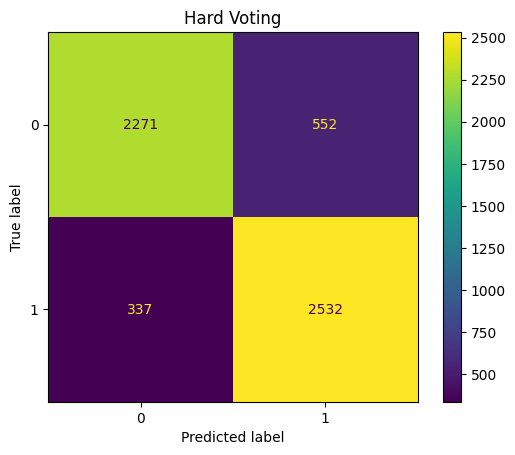

In [42]:
hard_conf_matrix = confusion_matrix(y_test, hard_results)
hard_conf_matrix_display = ConfusionMatrixDisplay(hard_conf_matrix)
hard_conf_matrix_display.plot()
plt.title("Hard Voting")
plt.show()

## Soft Voting

In [43]:
soft_results = soft_voting(X_test)

soft_results

array([[0.42360131, 0.57639869],
       [0.00670159, 0.99329842],
       [0.22293976, 0.77706024],
       ...,
       [0.71744337, 0.28255663],
       [0.05681698, 0.94318302],
       [0.93913755, 0.06086245]])

### Accuracy

In [47]:
soft_results_discrete = np.argmax(soft_results, axis=1)

accuracy_score(y_test, soft_results_discrete)

0.8462754743499649

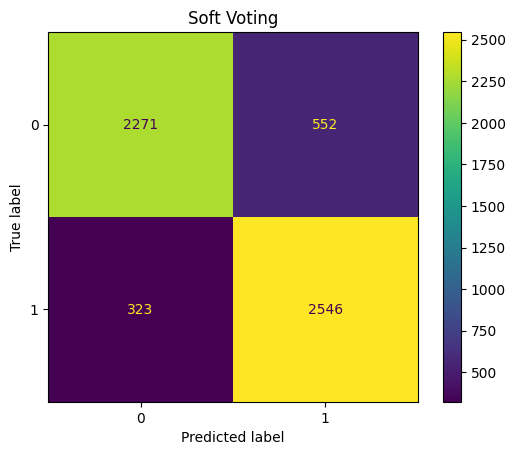

In [48]:
soft_conf_matrix = confusion_matrix(y_test, soft_results_discrete)
soft_conf_matrix_display = ConfusionMatrixDisplay(soft_conf_matrix)
soft_conf_matrix_display.plot()
plt.title("Soft Voting")
plt.show()

## Stacking

In [49]:
stacking_results = stacking(X_test)

stacking_results

array([[0.92793288, 0.07206712],
       [0.03433688, 0.96566312],
       [0.23681322, 0.76318678],
       ...,
       [0.99194343, 0.00805657],
       [0.0271874 , 0.9728126 ],
       [0.98279247, 0.01720753]])

### Accuracy

In [50]:
stacking_results_discrete = np.argmax(stacking_results, axis=1)

accuracy_score(y_test, stacking_results_discrete)

0.8608573436401967

### Confusion Matrix

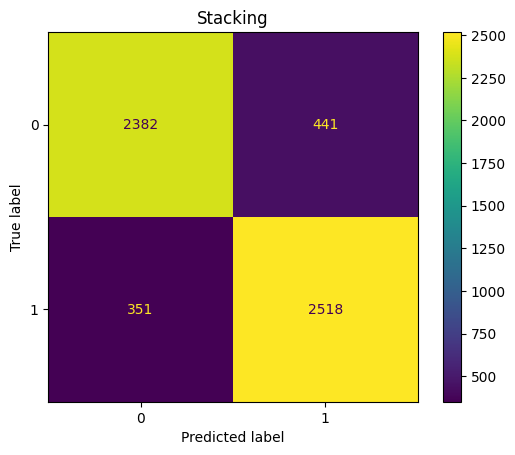

In [52]:
stacking_conf_matrix = confusion_matrix(y_test, stacking_results_discrete)
stacking_conf_matrix_display = ConfusionMatrixDisplay(stacking_conf_matrix)
stacking_conf_matrix_display.plot()
plt.title("Stacking")
plt.show()